In [2]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from simtk import unit
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 6, 4

# Pozo armónico



El potencial de tipo pozo armónico tiene en tres dimensiones la forma:

\begin{equation}
f(x,y,z)=\frac{1}{2} k \left(x^2 + y^2 + z^2 \right),
\end{equation}

donde $k$ es el parámetro que controla la apertura del pozo. Si atendemos a la fuerza que actua sobre una partícula en el pozo podemos ver que $k$ no es más que la constante de rigidez de un muelle ideal descrito clásicamente por la ley de Hook:

\begin{equation}
\vec{F}(x,y,z) = -\frac{d V(x)}{dx} \hat{x} - \frac{d V(y)}{dx} \hat{y} - \frac{d V(z)}{dz} \hat{z},
\end{equation}

\begin{equation}
\vec{F}(x,y,z) = -kx \hat{x} - ky \hat{y} - kz \hat{z}.
\end{equation}

Así, una partícula en el pozo se comporta como si estuviera sostenido
 independientemente por tres muelles, uno para cada dimensión, con sus correspondientes longitudes naturales igual a cero. Veamos el término de la coordenada $x$ del potencial representado gráficamente:

In [ ]:
def harmonic_well(x,k):
    return 0.5*k*x**2

In [ ]:
k=5.0 * unit.kilocalories_per_mole/ unit.nanometers**2 # stiffness of the harmonic potential

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers

plt.plot(x_serie, harmonic_well(x_serie, k), 'r-')
plt.ylim(-1,5)
plt.xlim(-2,2)
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energía ({})".format(unit.kilocalories_per_mole))
plt.title("Pozo Armónico")
plt.show()

La energía potencial del pozo armónico, en una dimensión, puede ser reescrita de la siguiente manera:

\begin{equation}
V(x) = \frac{1}{2} k x^{2} = \frac{1}{2} m \omega^{2} x^{2},
\end{equation}

donde la frecuencia angular $\omega$ de la oscilación de una partícula de masa $m$ en el pozo es:

\begin{equation}
\omega = \sqrt{\frac{k}{m}}
\end{equation}

Por último, el periodo de tiempo de la oscilación es por definición:

\begin{equation}
T = 2\pi / \omega
\end{equation}

Así que:

\begin{equation}
T = 2\pi \sqrt{\frac{m}{k}}
\end{equation}

## Simulación de la dinámica clásica newtoniana

Podemos simular de manera clásica (determinista) la trayectoria de una partícula en el pozo armónico acudiendo a la dinámica de Langevin a temperatura cero. Quizá no sea la forma más económica, pero esto nos permite rápidamente disponer de un integrador en OpenMM que nos facilita trabajar con un sistema libre o amortiguado. Veamos en primer lugar la secuencia de instrucciones para dicha simulación.

In [ ]:
# %load scripts/pozo_armonico_newtoniano_1.py
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit
import pickle

# Definición del sistema.
n_particles = 1 # número de partículas
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molécule diatómica: C-O

# Definición del potencial externo
k = 10 * unit.kilocalories_per_mole/unit.angstrom**2
force = mm.CustomExternalForce('0.5*k*(x^2 + y^2 + z^2)')
force.addGlobalParameter('k', k)

# Definición de las condiciones del estado termodinámico.
temperature = 0*unit.kelvin # temperatura a zero para que langevin simule la dinámica clásica

# Condiciones iniciales
initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers # posiciones iniciales
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds # velocidades iniciales

# Parámetros de la simulación.
integration_timestep = 0.1*unit.picoseconds # paso del integrador
saving_timestep = 1*unit.picoseconds # tiempo de guardado
total_time = 1*unit.nanoseconds # tiempo total de simulación

n_steps = int(round(total_time/integration_timestep)) # número total de pasos de integración a simular
steps_per_cicle = int(round(saving_timestep/integration_timestep)) # pasos de integración por ciclo de guardado
n_cicles = int(round(n_steps/steps_per_cicle)) # número total de ciclos de guardado a simular

# Creación del sistema.
system = mm.System()
for ii in range(n_particles):
    system.addParticle(mass)
    force.addParticle(ii, [])

system.addForce(force)

# Creación del integrador.
friction = 0.0/unit.picosecond # fricción del sistema (0.0/unit.picoseconds si no queremos fricción)
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Creación de la plataforma.
platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Creación del contexto.
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Creación de arrays reporteros del tiempo, la posición y la velocidad.
times = np.zeros([n_cicles], np.float32) * unit.picoseconds
positions = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocities = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0
state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Ejecuto el bucle sobre el número de ciclos de guardado que vamos a simular
for ii in range(1,n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

# Guardo, si es necesario, en un fichero pickle el resultado de la simulación
filename_traj = 'trajectory.pickle'
file_traj = open(filename_traj,'wb')
pickle.dump( times, file_traj )
pickle.dump( positions, file_traj )
pickle.dump( velocities, file_traj )
pickle.dump( kinetic_energy, file_traj )
pickle.dump( potential_energy, file_traj )
file_traj.close()



Esta misma sequencia de ordenes se encuentra encapsulada en forma de clases y métodos en la librería UIBCDF_Test_Systems. El propósito de esta librería es poder ejecutar simulaciones sencillas de una manera rápida sin tener que reescribir cada vez el script anterior. Veamos cómo podemos recurrir a ella para observar en primer lugar el comportamiento clásico no amortiguado de una partícula en nuestro pozo armónico:

In [ ]:
from uibcdf_test_systems import HarmonicWell
from uibcdf_test_systems.simulation import newtonian
from simtk import unit

mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducida de la molécula C-O
k = 10 * unit.kilocalories_per_mole/unit.nanometers**2 # parámetro k del potencial

# Clase Test con el sistema de OpenMM como atributo
harmonic_well = HarmonicWell(n_particles = 1, mass = mass, k=k)

# Posiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_positions[0,0] = 1.0 * unit.nanometers

# Simulación Newtoniana
time, position, velocity, kinetic_energy, potential_energy = newtonian (harmonic_well.system,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.01 * unit.picoseconds,
                                                                        saving_timestep = 0.1 * unit.picoseconds,
                                                                        total_time = 10 * unit.picoseconds)

Veamos el comportamiento de la posición de la partícula en el eje $X$ en función del tiempo. Podemos comprobar que efectivamente la expresión anterior del periodo $T$ tiene como resultado el tiempo entre oscilaciones en nuestra simulación:

In [ ]:
T = 2*np.pi*np.sqrt(mass/k)

print('El periodo de oscilación es',T)

In [ ]:
plt.plot(time, position[:,0,0])
plt.axvline(T._value, color='gray', linestyle='--') # Periodo de oscilaciones armónicas
plt.xlabel('tiempo ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

Recuerda que el paso de integración debe ser tan pequeño como al menos $\approx T/10$ para que el integrador no de problemas.

Podemos ahora ver el caso del oscilador amortiguado:


In [ ]:
# Simulación Newtoniana
time, position, velocity, kinetic_energy, potential_energy = newtonian (harmonic_well.system,
                                                                        friction = 0.5 / unit.picoseconds,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.01 * unit.picoseconds,
                                                                        saving_timestep = 0.1 * unit.picoseconds,
                                                                        total_time = 50 * unit.picoseconds)

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('tiempo ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

El oscilador armónico puede comportarse de manera sobre-amortiguada:

In [ ]:
# Simulación Newtoniana
time, position, velocity, kinetic_energy, potential_energy = newtonian (harmonic_well.system,
                                                                        friction = 10.0 / unit.picoseconds,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.01 * unit.picoseconds,
                                                                        saving_timestep = 0.1 * unit.picoseconds,
                                                                        total_time = 50 * unit.picoseconds)

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('tiempo ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

## Simulación de la dinámica de Langevin

Para simular el comportamiento del sistema a cierta temperatura recurriremos a las ecuaciones de la dinámica de Langevin. La trayectoria ahora será ahora ruidosa debido al término de modelado de la fluctuación. Veamos en primer lugar cómo podemos simular el sistema con OpenMM:

In [ ]:
# %load scripts/pozo_armonico_langevin_1.py
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit
import pickle

# Definición del sistema.
n_particles = 1 # número de partículas
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molécule diatómica: C-O

# Definición del potencial externo
k = 10 * unit.kilocalories_per_mole/unit.nanometers**2
force = mm.CustomExternalForce('0.5*k*(x^2 + y^2 + z^2)')
force.addGlobalParameter('k', k)

# Definición de las condiciones del estado termodinámico.
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin # temperatura a zero para que langevin simule la dinámica clásica
kBT = kB * temperature

# Condiciones iniciales
initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers # posiciones iniciales
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds # velocidades iniciales

# Parámetros de la simulación.
integration_timestep = 0.1*unit.picoseconds # paso del integrador
saving_timestep = 1*unit.picoseconds # tiempo de guardado
total_time = 1*unit.nanoseconds # tiempo total de simulación

n_steps = int(round(total_time/integration_timestep)) # número total de pasos de integración a simular
steps_per_cicle = int(round(saving_timestep/integration_timestep)) # pasos de integración por ciclo de guardado
n_cicles = int(round(n_steps/steps_per_cicle)) # número total de ciclos de guardado a simular

# Creación del sistema.
system = mm.System()
for ii in range(n_particles):
    system.addParticle(mass)
    force.addParticle(ii, [])

system.addForce(force)

# Creación del integrador.
friction = 1.0/unit.picosecond # fricción del sistema (0.0/unit.picoseconds si no queremos fricción)
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Creación de la plataforma.
platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Creación del contexto.
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Creación de arrays reporteros del tiempo, la posición y la velocidad.
times = np.zeros([n_cicles], np.float32) * unit.picoseconds
positions = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocities = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0
state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Ejecuto el bucle sobre el número de ciclos de guardado que vamos a simular
for ii in range(1,n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

# Guardo, si es necesario, en un fichero pickle el resultado de la simulación
filename_traj = 'trajectory.pickle'
file_traj = open(filename_traj,'wb')
pickle.dump( times, file_traj )
pickle.dump( positions, file_traj )
pickle.dump( velocities, file_traj )
pickle.dump( kinetic_energy, file_traj )
pickle.dump( potential_energy, file_traj )
file_traj.close()



La dinámica de Langevin está incluida también en la librería UIBCDF_Test_Systems, así que también podemos recurrir a ella para realizar de manera más económica unas sencillas simulaciones para ilustrar el coportamiento de este sistema.

In [58]:
from uibcdf_test_systems import HarmonicWell
from uibcdf_test_systems.simulation import langevin_NVT
from simtk import unit

mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducida de la molécula C-O
k = 10 * unit.kilocalories_per_mole/unit.nanometers**2 # parámetro k del potencial

# Clase Test con el sistema de OpenMM como atributo
harmonic_well = HarmonicWell(n_particles = 1, mass = mass, k=k)

# Posiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_positions[0,0] = 1.0 * unit.nanometers

# Simulación Newtoniana
time, position, velocity, kinetic_energy, potential_energy = langevin_NVT (harmonic_well.system,
                                                                           temperature = 300 * unit.kelvin,
                                                                           friction = 1.0 / unit.picoseconds,
                                                                           initial_positions = initial_positions,
                                                                           initial_velocities = initial_velocities,
                                                                           integration_timestep = 0.1 * unit.picoseconds,
                                                                           saving_timestep = 0.5 * unit.picoseconds,
                                                                           total_time = 5 * unit.nanoseconds)

In [59]:
kinetic_energy.shape

(10000, 1, 3)

Veamos que forma tiene la trayectoria en cualquiera de las tres dimensiones ahora:

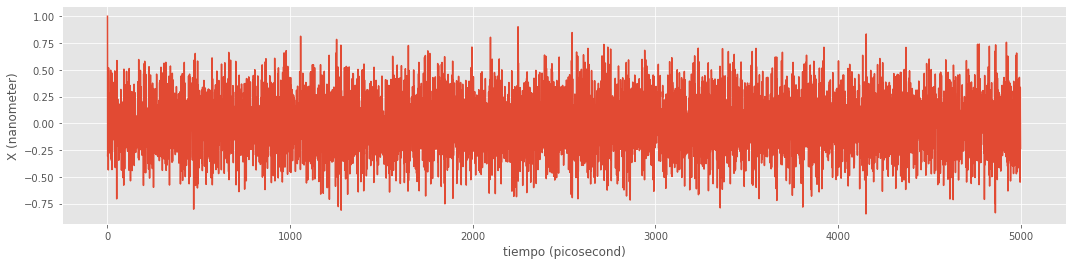

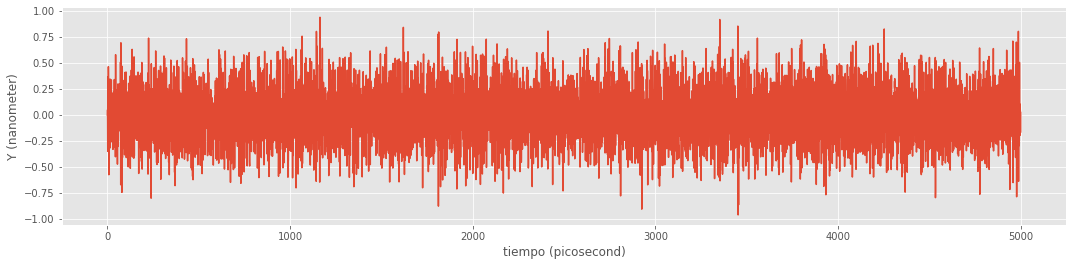

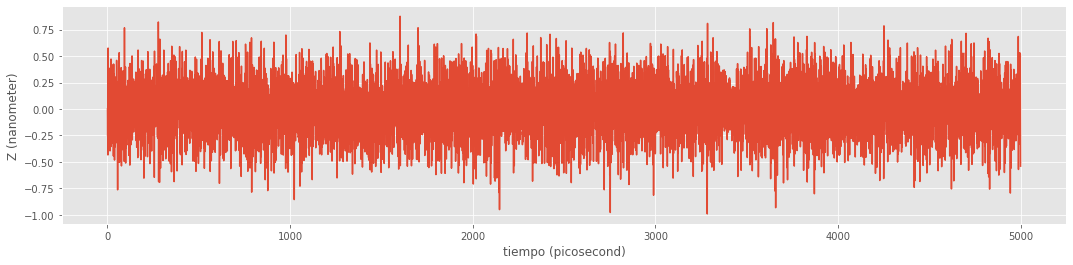

In [7]:
plt.rcParams['figure.figsize'] = 18, 4

for coor_index, coor_label in zip(range(3),['X','Y','Z']):
    plt.plot(time,position[:,0,coor_index])
    plt.xlabel('tiempo ({})'.format(time.unit))
    plt.ylabel('{} ({})'.format(coor_label, position.unit))
    plt.show()

Podemos ver la probabilidad de encontrar a la partícula en cierta coordenada del eje $X$:

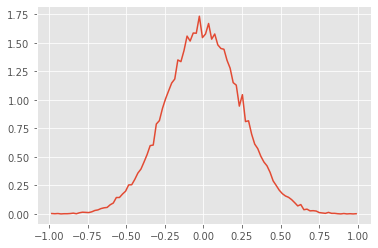

In [15]:
plt.rcParams['figure.figsize'] = 6, 4
hist, bin_edges = np.histogram(position[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

Y la energía libre proyectada sobre el eje $X$:

/home/diego/Myopt/miniconda3/envs/UIBCDF_lab_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


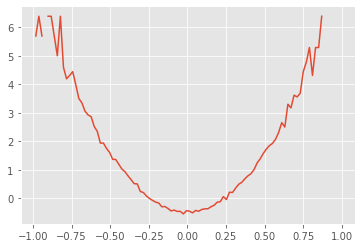

In [16]:
plt.rcParams['figure.figsize'] = 6, 4
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

Desde el diseño del potencial conocemos que la posición esperada promedio es cero para cada dimensión y la desviación estandard esperada promedio de la posición tiene una relación directa con la energía potencial:

\begin{equation}
\langle x \rangle = 0.0
\end{equation}

\begin{equation}
\sigma_{x}^{2} = \langle \left(x -\langle x \rangle \right) ^{2} \rangle = \langle x^{2} \rangle - \langle x \rangle^{2}= \langle x^{2} \rangle
\end{equation}


\begin{equation}
\langle U_{pot} \rangle = \frac{1}{2} k (\langle x^{2} \rangle + \langle y^{2} \rangle + \langle z^{2} \rangle) = \frac{1}{2} k \left( \sigma_{x}^{2} + \sigma_{y}^{2} + \sigma_{z}^{2} \right)
\end{equation}


In [18]:
print('La coordenada X promedio es {}'.format(np.mean(position[:,0,0])))

La coordenada X promedio es -0.0025032184 nm


In [19]:
print('La energía potencial promedio es {}'.format(np.mean(potential_energy[:,0])))

La energía potencial promedio es 0.90614283 kcal/mol


Podemos ver como converge el promedio de una magnitud con el tiempo. O dicho de otra manera, veamos el promedio de una magnitud en cualquier tiempo $t'$ observando la trayectoria en el intervalo $t:[0,t']$. Veamos por ejemplo cómo se comportan $\langle x \rangle$, $\langle x^2 \rangle$, y la energía cinética promedio $\langle U_{kin} \rangle$:  

In [43]:
n_frames = position.shape[0]
average_x_in_time   = unit.Quantity(np.zeros(n_frames, np.float32), unit.nanometers)
average_x2_in_time  = unit.Quantity(np.zeros(n_frames, np.float32), unit.nanometers**2)
average_kinetic_energy_in_time =  unit.Quantity(np.zeros(n_frames, np.float32), unit.kilocalorie_per_mole)

for ii in np.arange(n_frames):
    average_x_in_time[ii] = np.mean(position[:(ii+1),0,0])
    average_x2_in_time[ii]  = np.mean(position[:(ii+1),0,0]**2)
    average_kinetic_energy_in_time[ii] =  np.mean(kinetic_energy[:(ii+1),0])

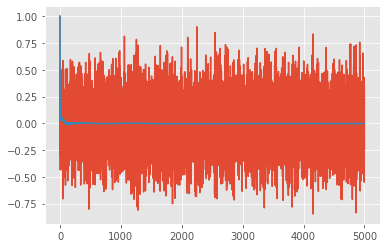

In [47]:
plt.plot(time,position[:,0,0])
plt.plot(time,average_x_in_time)
plt.show()

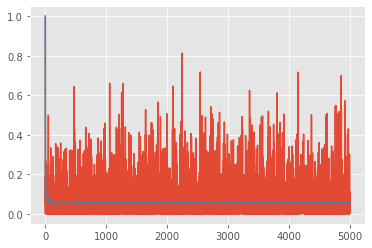

In [48]:
plt.plot(time,position[:,0,0]**2)
plt.plot(time,average_x2_in_time)
plt.show()

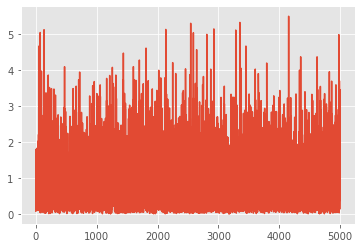

In [56]:
plt.plot(time,kinetic_energy[:,0,0])
#plt.plot(time,average_kinetic_energy_in_time[:])
plt.show()

In [57]:
kinetic_energy.shape

(10000, 1, 3)

Veamos ahora la velocidad de la partícula en función del tiempo:

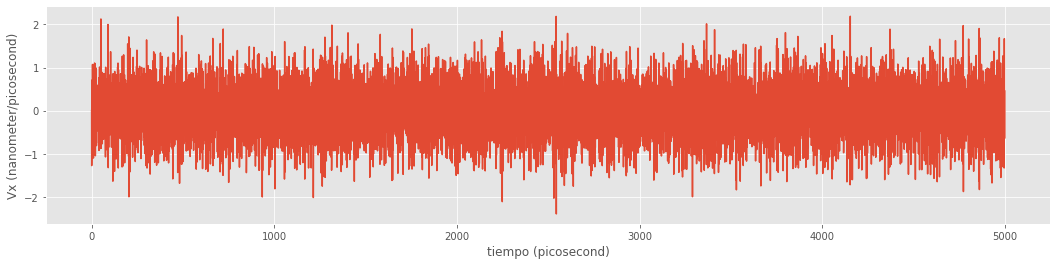

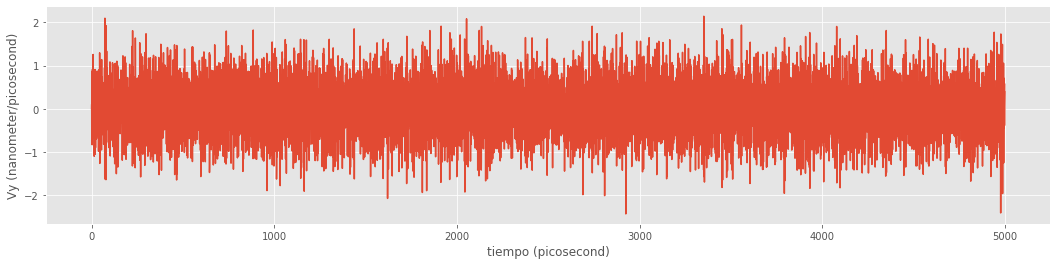

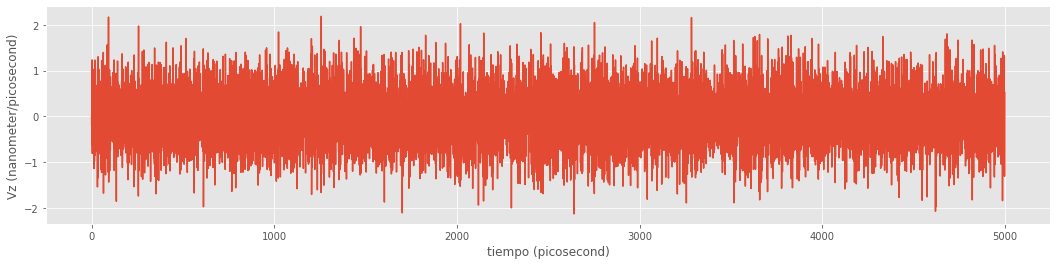

In [14]:
plt.rcParams['figure.figsize'] = 18, 4

for vel_index, vel_label in zip(range(3),['Vx','Vy','Vz']):
    plt.plot(time,velocity[:,0,vel_index])
    plt.xlabel('tiempo ({})'.format(time.unit))
    plt.ylabel('{} ({})'.format(vel_label, velocity.unit))
    plt.show()

Veamos que se cumple la relación entre la energía cinética promedio y la temperatura:

\begin{equation}
\langle U_{kin} \rangle = \frac{3}{2} k_{B} T
\end{equation}

In [26]:
average_kinetic_energy = np.mean(kinetic_energy[:,0])
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kBT = kB * 300 * unit.kelvin
theoric_average_kinetic_energy = ((3.0/2.0)* kBT).in_units_of(unit.kilocalorie_per_mole)
print('La energía cinética promedio es {}'.format(average_kinetic_energy))
print('Y por el principio de equipartición de la energía debería {}'.format(theoric_average_kinetic_energy))

La energía cinética promedio es 0.8917857 kcal/mol
Y por el principio de equipartición de la energía debería 0.894242976111161 kcal/mol


De hecho podríamos calcular la temperatura promedio del sistema de la energía cinética:
\begin{equation}
T = \frac{2\langle U_{kin} \rangle}{3k_{B}}
\end{equation}

La energía potencial promedio debe ser igual a la energía cinética promedio:

\begin{equation}
\langle U_{kin} \rangle=\langle U_{pot} \rangle
\end{equation}

\begin{equation}
\langle U_{pot} \rangle= \frac{3}{2} k_{B} T
\end{equation}

In [28]:
average_potential_energy = np.mean(potential_energy[:,0])
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kBT = kB * 300 * unit.kelvin
theoric_average_potential_energy = ((3.0/2.0)* kBT).in_units_of(unit.kilocalorie_per_mole)
print('La energía cinética promedio es {}'.format(average_potential_energy))
print('Y por el principio de equipartición de la energía debería {}'.format(theoric_average_potential_energy))

La energía cinética promedio es 0.90614283 kcal/mol
Y por el principio de equipartición de la energía debería 0.894242976111161 kcal/mol


De hecho, en el caso del pozo armónico, esta relación nos puede servir para calcular la desviación estandard de la posición en función de la temperatura:

\begin{equation}
\langle \frac{1}{2} k (x^2 + y^2 +z^2) \rangle= \frac{3}{2} k_{B} T
\end{equation}

\begin{equation}
\langle x^2 \rangle= \frac{k_{B} T}{k}
\end{equation}

Ya que por construcción:

\begin{equation}
\langle x^2 \rangle= \langle y^2 \rangle = \langle z^2 \rangle
\end{equation}

Que en este caso, y dado que $\langle x \rangle=0$, podemos reescribir como:

\begin{equation}
\sigma_{x}^2= \frac{k_{B} T}{k}
\end{equation}


In [36]:
std_x = np.std(position[:,0,:])
print('La desviación cuadrática estandard en X es {}'.format(std_x**2))
print('y según kBT/k es {}'.format(kBT/k))

La desviación cuadrática estandard en X es 0.06040951074348677 nm**2
y según kBT/k es 0.059616198407410705 nm**2


Quantity(value=0.059616198407410705, unit=nanometer**2)

# Paisaje Energía Potencial

In [ ]:
x = sy.symbols('x')
f=0.5*K*x**2

g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

# Condiciones iniciales

In [ ]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

# Análisis de resultados

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
plt.plot(times,kinetic_energies)

In [ ]:
plt.plot(times,potential_energies)

T = sqrt(m/K) timestep smaller than ~ T/10 standard deviation in each dimension sigma= (kT / K)^(1/2) Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT

# TODO
- comprobar con que damping es sobre-amortiguado
- comprobar el delta de maximo permitido
- comprobar la energía por grado de libertad
- comprobar la distribución de velocidades
- comprobar la energía cinética promedio
- comprobar la dependencia con la masa
- comprobar que el periodo está bien calculado